# Optimizations
1.GradienDecent

2.NewtonMethod

3.DampedNewtonMethod

4.ReviseNewtonMethod

5.DFP

6.BFGS

7.L_BFGS


In [1]:
from IPython.display import display, Math, Latex
from sympy import *
import numpy as np

import matplotlib
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import numpy as np
%matplotlib inline

disFunc = lambda s : display(Math(s))

Define test function


<IPython.core.display.Math object>

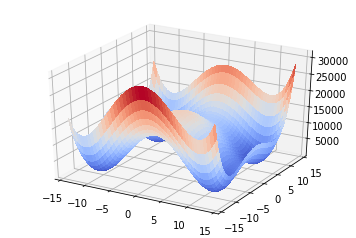

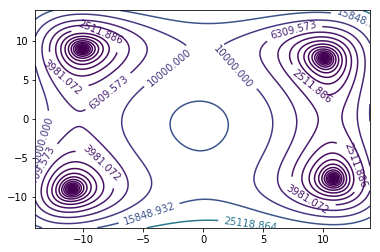

In [128]:
x = Symbol('x')
y = Symbol('y')

print('Define test function')
f    = (x**2 + y -110)**2+(x + y**2 -70)**2
disFunc('f = f(x_1,x_2) = '+latex(f))
    
'Change the symbolic function into numpy function'
f_np = lambdify((x,y), f, "numpy")

'Plot the Test function'
# Make data.
paras=[-14, 14, 0.1]
X = np.arange(*paras)
Y = np.arange(*paras)
X, Y = np.meshgrid(X, Y)
Z = f_np(X ,Y )

# Plot data.
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.plot_surface(X, Y, Z, cmap=cm.coolwarm,linewidth=0, antialiased=False)
plt.show()

fig = plt.figure()
cs=plt.contour(X, Y, Z, levels=10.0**np.arange(-2,5, 0.2) )
plt.clabel(cs, inline=1, fontsize=10)
plt.show()

In [3]:
"find out test function's differential fuction"

diff_x = diff(f,x)
disFunc("\\frac {\\partial f} {\\partial  x} = "+latex(diff_x))

diff_y = diff(f,y)
disFunc("\\frac {\\partial f} {\\partial y} = "+latex(diff_y))

print('Gradien vec')
grad = Matrix([diff_x,diff_y])
disFunc("G(X) = [\\frac {\\partial f} {\\partial x} , \\frac {\\partial f} {\\partial y} ] = "+latex(grad))

print('Hessian vec')
hess = hessian(f,(x,y))
# disFunc("X = [ x_1,x_2 ]")
disFunc("H(X) = "+latex(hess))


'Change the symbolic Gradien and Hessian into numpy function'
grad_np = lambdify((x,y), grad, "numpy")
hess_np = lambdify((x,y), hess, "numpy")

<IPython.core.display.Math object>

<IPython.core.display.Math object>

Gradien vec


<IPython.core.display.Math object>

Hessian vec


<IPython.core.display.Math object>

## 1.GradienDecent

In [4]:
def GradienDecent(X_0,fun,Gradient,lr=1e-3, rho=0.5,sigma = 0.4,epsilon=1e-5,Maxepoch=5000):
    dot = np.dot  
    norm = np.linalg.norm
    vals = X_0.T.copy()
#     print(Gradient(*vals))
    for i in range(Maxepoch):
        gk = Gradient(*vals)
        # -gk means function minimizing
        dk = -gk
        if norm(dk) < epsilon:  break    
            
        vals += lr * dk.T[0]
        yield vals,fun(*vals)
        
#         This part is extended reading, which called linear search, intend to find out good gradient step-size
#         In other words,'learning rate' of gradient
#         m,mk = (0,0)
#         f0 = fun(*vals)
#         for m in range(20):
#             v1 = (vals+rho**m*dk.T[0])
#             f1 = fun(*v1)
#             if f1 < f0 + sigma*rho**m*gk.T.dot(dk):
#                 mk=m
#                 break        
#         vals += rho**mk* dk.T[0]
#         if mk==0:
#             yield vals,f0
#         else:
#             yield vals,f1

In [5]:
np_toFloat = lambda x : np.asarray(x).astype(np.float32)
processList=np.zeros((5001,3))
processList[0] = [0,-1, f_np(0,-1)]
# set counter 
cnt=1
for i in GradienDecent( processList[0][:2], f_np,grad_np):
    processList[cnt]=np.append(i[0],i[-1])
    cnt+=1
processList=processList[:cnt]
print('GradienDecent converged at step :',cnt-1)
print('GradienDecent converged minimization :',processList[-1])

GradienDecent converged at step : 45
GradienDecent converged minimization : [  1.08485482e+01  -7.69099809e+00   3.91932314e-14]


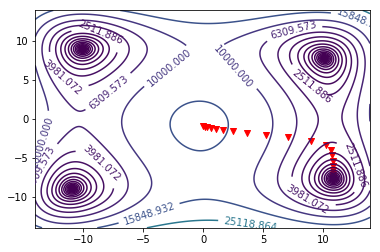

In [6]:
'Show how is it moving'
fig = plt.figure()
plt.clabel( plt.contour(X, Y, Z, levels=10.0**np.arange(-2,5, 0.2)), inline=1, fontsize=10)
plt.scatter(*processList.T[:2].tolist(), c='r', marker='v')
plt.show() 

## 7.L_BFGS
2 to 6 method will introduce at the end

In [76]:
def L_BFGS(X_0,fun,Gradient,lr=0.9, memo=5, rho=0.5 ,sigma = 0.4,epsilon=1e-5, Maxepoch=5000, timing=False):
    import time
    start = time.time()
    norm = np.linalg.norm
    vals = X_0.copy()
    s = [];y = [];Rho = [];alpha = list(range(memo));beta = list(range(memo))
    
    for k in range(Maxepoch):
        gk = Gradient(*vals)
        if norm(gk) < epsilon: break
        if timing : print('get Gradient cost(s):',time.time()-start);start = time.time()
            
        q = gk.copy()
        
        for i in range(len(s)-1,-1,-1):
            alpha[i] =  Rho[i] * np.sum(s[i]*q)
            q -= alpha[i] * y[i]
            
        h0 = np.sum(s[-1]*y[-1])/np.sum(y[-1]*y[-1]) if k >0 else 1
        z = h0 * q

        for i in range(len(s)):
            beta = Rho[i] * np.sum(z*y[i])
            z += (alpha[i]-beta) * s[i]
            
        dk = -z          
#         linear search
#         m,mk = (0,0)
#         f0 = fun(*vals)
#         for m in np.arange(0,5,1):
#             v1 = (vals + rho**m * dk.T[0])
#             f1 = fun(*v1)
#             if f1 < f0 + sigma* rho**m * np.sum(dk*gk):
#                 mk=m
#                 break  
              
        if len(s) >= memo: s.pop(0);y.pop(0);Rho.pop(0)
            
        s.append(lr * dk)#1e-1 * dk)#rho**mk * dk)
        vals += s[-1].T[0]
        if timing : print('L_BFGS process1 cost(s):',time.time()-start);start = time.time()
        f0=fun(*vals)
        if timing : print('get fun cost(s):',time.time()-start);start = time.time()
        y.append( Gradient(*vals) - gk )
        if timing : print('L_BFGS Gradient2 cost(s):',time.time()-start);start = time.time()
        Rho.append( 1/np.sum(y[-1]*s[-1]) )
#         print(f0)
#         if mk==0:
#             yield vals,f0
#         else:
#             yield vals,f1
        if timing : print('L_BFGS process2 cost(s):',time.time()-start);start = time.time()
        yield vals,f0

In [8]:
np_toFloat = lambda x : np.asarray(x).astype(np.float32)
processList=np.zeros((5001,3))
processList[0] = [0,-1, 0]
processList[0,2] = f_np(*processList[0][:2])
cnt=1
for i in L_BFGS( processList[0][:2], f_np,grad_np):
    processList[cnt]=np.append(i[0],i[-1])
    cnt+=1
processList=processList[:cnt]
print('L_BFGS converged at step :',cnt-1)
print('L_BFGS converged minimization :',processList[-1])

L_BFGS converged at step : 14
L_BFGS converged minimization : [  1.08485482e+01  -7.69099810e+00   5.70545410e-15]


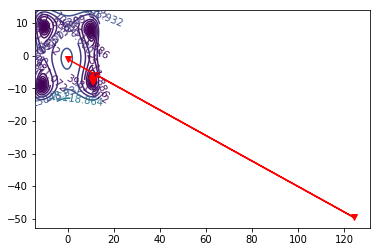

In [9]:
'Show how is it moving'
fig = plt.figure()
plt.clabel( plt.contour(X, Y, Z, levels=10.0**np.arange(-2,5, 0.2)), inline=1, fontsize=10)
plt.plot(*processList.T[:2].tolist(), c='r', marker='v')
plt.show() 

### Summary
Both Gradient descent and L_BFGS are very practical optimization method nowaday.

But we can rarely see L_BFGS be used at machine learning. So sometimes you must code it yourself.

In [10]:
'L_BFGS scipy implement'
from scipy.optimize import minimize
def f_np2(x):
    return f_np(*x)
def grad_np2(x):
    return grad_np(*x)
res = minimize(method='L-BFGS-B', x0=[0,-1], fun=f_np2, jac=grad_np2, options={'gtol': 1e-5, 'disp': True})
res

      fun: 3.0471931068748683e-16
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([[ -6.68529546e-07],
       [ -2.62898647e-07]])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 18
      nit: 9
   status: 0
  success: True
        x: array([ 10.8485482,  -7.6909981])

### Apply L_BFGS to machine learning

In [91]:
'Codes here are the same as Tutorial 2'
import pickle, gzip
# Load the dataset
f = gzip.open('mnist.pkl.gz', 'r')
train_set, valid_set, test_set = pickle.load(f,encoding='latin1')
f.close()
(X_train, y_train) = train_set
(X_valid, y_valid) = valid_set
(X_test, y_test) = test_set
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(y_train)
y_train = lb.transform(y_train);y_valid = lb.transform(y_valid);y_test = lb.transform(y_test)

print('X_train.shape',X_train.shape,'\t y_train.shape',y_train.shape)

def getRandBatch(samples,batchSize=3000):
    return np.random.choice(np.arange(samples),batchSize).astype(np.int32)

batchIdx = getRandBatch(len(X_train))
batchTrain = X_train[batchIdx,:].astype(np.float32)
batchTrainLabels = y_train[batchIdx,:].astype(np.float32)

'input :784 units, output layer:10 units'
layers=(784, 10)
NN = np.random.rand(*layers).astype(np.float32)*2-1
print('NN.shape',NN.shape)

X_train.shape (50000, 784) 	 y_train.shape (50000, 10)
NN.shape (784, 10)


In [84]:
def softmax(x):
    tmp=np.exp(x-x.max(1).reshape(-1,1))
    return tmp/tmp.sum(1).reshape(-1,1)

def mean_entropy(predict,y):
    return (-y*np.log(predict)).sum(1).mean()

# batchTrain = X_train[:,:]
# batchTrainLabels = y_train[:,:]
def f_NN(NN):
    batchIdx = getRandBatch(len(X_train))
    batchTrain = X_train[batchIdx,:].astype(np.float32)
    batchTrainLabels = y_train[batchIdx,:].astype(np.float32)
    
    predict=softmax(batchTrain.dot(NN.reshape(layers)))
    return mean_entropy(predict, batchTrainLabels)

def grad_NN(NN):
    error = batchTrainLabels - softmax(batchTrain.dot(NN.reshape(layers)))
    return (batchTrain.T.dot(error)/len(batchTrainLabels)).flatten()

In [85]:
'Try it on scipy implement first'
from scipy.optimize import  minimize
import time
start = time.time()
res = minimize(method='L-BFGS-B', x0=NN, fun=f_NN, jac=grad_NN, options={'gtol': 1e-5, 'disp': True})
print(res)
predict=softmax(batchTrain.dot(res.x.reshape(layers)))
print('final acc:',(np.argmax(predict,1)==np.argmax(batchTrainLabels,1)).sum()/len(batchTrainLabels)*100 )    
print('cost time:',time.time()-start)

      fun: 10.184093689399599
 hess_inv: <7840x7840 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 0.,  0.,  0., ...,  0.,  0.,  0.])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 7
      nit: 1
   status: 0
  success: True
        x: array([ 0.83734775, -0.90052313,  0.6618644 , ..., -0.3431325 ,
        0.23017645,  0.87996709])
final acc: 11.8333333333
cost time: 0.7820446491241455


### Neither batch set nor  all data set on it result successfully 

In [86]:
'Try it on our implement'
'input :784 units, output layer:10 units'
layers=(784, 10)
NN = np.random.rand(*layers).astype(np.float32)*2-1
print('NN.shape',NN.shape)

NN.shape (784, 10)


In [97]:
batchTrain = X_train[:,:]
batchTrainLabels = y_train[:,:]
predict=softmax(batchTrain.dot(NN.reshape(layers)))
def f_NN(*NN):
    global batchIdx,batchTrain,batchTrainLabels,predict
#     batchIdx = getRandBatch(len(X_train))
#     batchTrain = X_train[batchIdx,:].astype(np.float32)
#     batchTrainLabels = y_train[batchIdx,:].astype(np.float32)
    NN = np.asarray(NN)
    predict=softmax(batchTrain.dot(NN.reshape(layers)))
    return mean_entropy(predict, batchTrainLabels)

def grad_NN(*NN):
    global batchIdx,batchTrain,batchTrainLabels,predict
    error = batchTrainLabels - predict
    return (batchTrain.T.dot(error)/len(batchTrainLabels)).flatten().reshape(-1,1)

In [98]:
import time
start = time.time()
maxepoch=10
processList=np.zeros((maxepoch+1,7841))
processList[0] = np.append(NN.flatten(),0)
processList[0,-1] = f_NN(NN.flatten())
cnt=1
for i in L_BFGS( processList[0][:-1], f_NN,grad_NN, lr=0.9, Maxepoch=maxepoch):
    processList[cnt]=np.append(i[0],i[-1])
    print('step:',cnt,',mean_entropy:',processList[cnt,-1])
    cnt+=1
processList=processList[:cnt]
print('L_BFGS converged at step :',cnt-1)
print('L_BFGS converged minimization :',processList[-1])
predict=softmax(batchTrain.dot(processList[-1,:-1].reshape(layers)))
print('final acc:',(np.argmax(predict,1)==np.argmax(batchTrainLabels,1)).sum()/len(batchTrainLabels)*100 )   
print('cost time:',time.time()-start)

step: 1 ,mean_entropy: 11.9142410762
step: 2 ,mean_entropy: 5.05315366039
step: 3 ,mean_entropy: 3.61583108675
step: 4 ,mean_entropy: 2.65013924253
step: 5 ,mean_entropy: 2.00383570472
step: 6 ,mean_entropy: 1.40145070285
step: 7 ,mean_entropy: 1.12986059861
step: 8 ,mean_entropy: 0.94447490863
step: 9 ,mean_entropy: 0.855137132378
step: 10 ,mean_entropy: 0.789467100456
L_BFGS converged at step : 10
L_BFGS converged minimization : [ 0.85435486  0.28685248 -0.65199    ..., -0.82859743 -0.56774569
  0.7894671 ]
final acc: 82.094
cost time: 27.760104417800903


### Congratulation !! it works successfully, the mean_entropy was decresing.
That is why we need to code things ourself somtimes.

In [99]:
'Get it work at GPU, First we need timing'
import time
start = time.time()
maxepoch=3
processList=np.zeros((maxepoch+1,7841))
processList[0] = np.append(NN.flatten(),0)
processList[0,-1] = f_NN(NN.flatten())
cnt=1
for i in L_BFGS( processList[0][:-1], f_NN,grad_NN, Maxepoch=maxepoch, timing=True):
    processList[cnt]=np.append(i[0],i[-1])
    print('step:',cnt,',mean_entropy:',processList[cnt,-1])
    cnt+=1
processList=processList[:cnt]
print('L_BFGS converged at step :',cnt-1)
print('L_BFGS converged minimization :',processList[-1])
predict=softmax(batchTrain.dot(processList[-1,:-1].reshape(layers)))
print('final acc:',(np.argmax(predict,1)==np.argmax(batchTrainLabels,1)).sum()/len(batchTrainLabels)*100 )   
print('cost time:',time.time()-start)

get Gradient cost(s): 1.1010022163391113
L_BFGS process1 cost(s): 0.0
get fun cost(s): 0.3802027702331543
L_BFGS Gradient2 cost(s): 1.1404228210449219
L_BFGS process2 cost(s): 0.0
step: 1 ,mean_entropy: 11.9142410762
get Gradient cost(s): 1.1635143756866455
L_BFGS process1 cost(s): 0.0
get fun cost(s): 0.38060784339904785
L_BFGS Gradient2 cost(s): 1.1191112995147705
L_BFGS process2 cost(s): 0.0
step: 2 ,mean_entropy: 5.05315366039
get Gradient cost(s): 1.1218140125274658
L_BFGS process1 cost(s): 0.0
get fun cost(s): 0.3962078094482422
L_BFGS Gradient2 cost(s): 1.1250643730163574
L_BFGS process2 cost(s): 0.0
step: 3 ,mean_entropy: 3.61583108675
L_BFGS converged at step : 3
L_BFGS converged minimization : [ 0.85435486  0.28685248 -0.65199    ..., -0.82859743 -0.56774569
  3.61583109]
final acc: 31.08
cost time: 8.451373815536499


above shows that Gradient fun cost too much time, so make a GPU version of it

In [18]:
import reikna.cluda as cluda
api = cluda.cuda_api()#ocl_api()#.cuda_api() switch opencl and cuda
thr = api.Thread.create()

In [200]:
from reikna.linalg import MatrixMul
'input :784 units, output layer:10 units'
layers=(784, 10)
NN = np.random.rand(*layers).astype(np.float32)*2-1
NN_dev = thr.to_device(NN)

batchSize = len(X_train)
batchIdx = getRandBatch(len(X_train),batchSize)
batchTrain = X_train[batchIdx,:].copy().astype(np.float32)
batchTrain_dev = thr.to_device(batchTrain)

batchTrainLabels = y_train[batchIdx,:].copy().astype(np.float32)
batchTrainLabels_dev = thr.to_device(batchTrainLabels)

predict_dev = thr.array((batchSize,layers[-1]), dtype=np.float32)

GPUfeedforward = MatrixMul(batchTrain_dev, NN_dev, out_arr=predict_dev).compile(thr)
GPUfeedforward(predict_dev, batchTrain_dev, NN_dev)
# 'set up GPU feedforward fun'
print("Check GPU result with CPU result if they are the same :")
print(np.linalg.norm(predict_dev.get() - batchTrain.dot(NN_dev.get())) / np.linalg.norm(batchTrain.dot(NN_dev.get())) < 1e-6)

Check GPU result with CPU result if they are the same :
True


In [101]:
'set up a GPU softmax fun'
program = thr.compile("""
KERNEL void gpu_softmax(
    GLOBAL_MEM float *input
    )
{
    const SIZE_T i0 = get_global_id(0);
    const SIZE_T i1 = get_global_id(1);
    //why terminate?  because softmax need to sum up from [i,0] to [i,end]
    if(i1>0)return;

    int IDX = i0*get_global_size(1)+i1;
    float s = 0.0f;
    float max = 0.0f;
    for(int i=0;i<(int)get_global_size(1);i++){
        if(max<input[IDX+i])max=input[IDX+i];
    };
    for(int i=0;i<(int)get_global_size(1);i++){
      input[IDX+i]=exp(input[IDX+i]-max);
      s+=input[IDX+i];
    };
    for(int i=0;i<(int)get_global_size(1);i++){
      input[IDX+i]/=s;
    };
}
""")
gpu_softmax = program.gpu_softmax
def GPUsoftmax(predict_dev):
    gpu_softmax(predict_dev, local_size=(1,1), global_size=predict_dev.shape)
predict = predict_dev.get()
GPUsoftmax(predict_dev)
print("Check GPU result with CPU result if they are the same :")
print(np.linalg.norm(softmax(predict) -predict_dev.get()) / np.linalg.norm(predict_dev.get()) < 1e-6)

Check GPU result with CPU result if they are the same :
True


In [105]:
program = thr.compile("""
KERNEL void gpu_minus(
    GLOBAL_MEM float *a_dev,
    GLOBAL_MEM float *b_dev,
    GLOBAL_MEM float *res_dev
    )
{
    const SIZE_T id0 = get_global_id(0);
    const SIZE_T id1 = get_global_id(1);
    int IDX = id0*get_global_size(1)+id1;
    res_dev[IDX] = a_dev[IDX] - b_dev[IDX] ;
}
""")
gpu_minus = program.gpu_minus
def GPUminus(a_dev,b_dev,res_dev):
    gpu_minus(a_dev, b_dev, res_dev, local_size=(1,1), global_size=res_dev.shape)
    
grad_NN_dev = thr.empty_like(NN_dev)
error_dev = thr.empty_like(predict_dev)
GPUminus(batchTrainLabels_dev, predict_dev, error_dev)
# error_dev = batchTrainLabels_dev-predict_dev

GPUbackforward = MatrixMul(batchTrain_dev, error_dev, out_arr=grad_NN_dev,transposed_a=True).compile(thr)
GPUbackforward(grad_NN_dev, batchTrain_dev, error_dev)
print("Check GPU result with CPU result if they are the same :")
print(np.linalg.norm(grad_NN_dev.get() - batchTrain.T.dot(error_dev.get())) / np.linalg.norm(batchTrain.T.dot(error_dev.get())) < 1e-5 )

Check GPU result with CPU result if they are the same :
True


In [103]:
def L_BFGS(X_0,fun,Gradient,lr=0.9, memo=5, rho=0.5 ,sigma = 0.4,epsilon=1e-5, Maxepoch=5000, timing=False):
    import time
    start = time.time()
    norm = np.linalg.norm
    vals = X_0.copy()
    s = [];y = [];Rho = [];alpha = list(range(memo));beta = list(range(memo))
    
    for k in range(Maxepoch):
        gk = Gradient(vals)
        if norm(gk) < epsilon: break            
        q = gk.copy()        
        
        for i in range(len(s)-1,-1,-1):
            alpha[i] =  Rho[i] * np.sum(s[i]*q)
            q -= alpha[i] * y[i]
            
        h0 = np.sum(s[-1]*y[-1])/np.sum(y[-1]*y[-1]) if k >0 else 1
        z = h0 * q

        for i in range(len(s)):
            beta = Rho[i] * np.sum(z*y[i])
            z += (alpha[i]-beta) * s[i]
            
        dk = -z         
        if len(s) >= memo: s.pop(0);y.pop(0);Rho.pop(0)
            
        s.append(lr * dk)
        vals += s[-1].T[0]
        f0=fun(vals)
        y.append( Gradient(vals) - gk )
        Rho.append( 1/np.sum(y[-1]*s[-1]) )
        yield vals,f0

In [104]:
def softmax(x):
    tmp=np.exp(x-x.max(1).reshape(-1,1))
    return tmp/tmp.sum(1).reshape(-1,1)

def mean_entropy(predict,y):
    return (-y*np.log(predict)).sum(1).mean()

In [202]:

def GPU_f_NN(NN):
    global batchSize,batchIdx,batchTrain,batchTrainLabels,batchTrain_dev,predict_dev,batchTrainLabels_dev,batchTrain_dev_T,NN_dev
    
    'I used all data set, if you want to try on a batch, compile it from begin again'
#     batchIdx = getRandBatch(len(X_train),batchSize)
#     batchTrain = X_train[batchIdx,:].astype(np.float32)
#     batchTrainLabels = y_train[batchIdx,:].astype(np.float32)
    
#     batchTrain_dev = thr.to_device(batchTrain)
#     batchTrainLabels_dev = thr.to_device(batchTrainLabels)    
#     batchTrain_dev_T = thr.to_device(batchTrain.T.copy())
    
    NN_dev = thr.to_device(np.asarray(NN).reshape(layers).astype(np.float32))
    GPUfeedforward(predict_dev, batchTrain_dev, NN_dev)    
    GPUsoftmax(predict_dev)
    return mean_entropy(predict_dev.get(), batchTrainLabels)

def GPU_grad_NN(NN):
    global batchIdx,batchTrain,batchTrainLabels,batchTrain_dev,predict_dev,batchTrainLabels_dev,batchTrain_dev_T,grad_NN_dev,NN_dev
#     NN_dev = thr.to_device(np.asarray(NN).reshape(layers).astype(np.float32))
#     GPUfeedforward(predict_dev, batchTrain_dev, NN_dev)
#     GPUsoftmax(predict_dev)
#     predict_dev.get()
    GPUminus(batchTrainLabels_dev, predict_dev, error_dev)
    GPUbackforward(grad_NN_dev, batchTrain_dev, error_dev)    
    return (grad_NN_dev.get()/len(batchTrainLabels)).flatten().reshape(-1,1)

In [211]:
'Get it work at GPU'
import time
start = time.time()
maxepoch=10
processList=np.zeros((maxepoch+1,7841))
processList[0] = np.append(NN.flatten(),0)
processList[0,-1] = GPU_f_NN(NN.flatten())
cnt=1
for i in L_BFGS( processList[0][:-1], GPU_f_NN, GPU_grad_NN, lr=0.9, Maxepoch=maxepoch, timing=False):
    processList[cnt]=np.append(i[0],i[-1])
    print('step:',cnt,',mean_entropy:',processList[cnt,-1])
    cnt+=1
processList=processList[:cnt]
print('L_BFGS converged at step :',cnt-1)
print('L_BFGS converged minimization :',processList[-1])
predict=softmax(X_test.dot(processList[-1,:-1].reshape(layers)))
print('final acc:',(np.argmax(predict,1)==np.argmax(y_test,1)).sum()/len(X_test)*100 )   
print('cost time:',time.time()-start)

step: 1 ,mean_entropy: 12.995847702
step: 2 ,mean_entropy: 4.68620491028
step: 3 ,mean_entropy: 3.58424592018
step: 4 ,mean_entropy: 2.91162872314
step: 5 ,mean_entropy: 2.22152161598
step: 6 ,mean_entropy: 1.58387219906
step: 7 ,mean_entropy: 1.18390214443
step: 8 ,mean_entropy: 1.07198047638
step: 9 ,mean_entropy: 0.927159905434
step: 10 ,mean_entropy: 0.872320830822
L_BFGS converged at step : 10
L_BFGS converged minimization : [ 0.44296205 -0.38092399  0.13241339 ...,  0.30457795 -0.65480131
  0.87232083]
final acc: 80.5
cost time: 2.0959255695343018


## Summary
Comparing to previous CPU version's cost time of 27s,

GPU version cost time of 2s

10 times FASTER!!

## 2-6. 
2.NewtonMethod,
3.DampedNewtonMethod,
4.ReviseNewtonMethod,
5.DFP,
6.BFGS

In [179]:
np_toFloat = lambda x : np.asarray(x).astype(np.float32)
        
def NewtonMethod(X_0,Gradient,Hessian,epsilon=1e-5,Maxepoch=5000):
    dot = np.dot
    inv = np.linalg.inv
    norm = np.linalg.norm
    
#     symbols,vals = zip(*X_0)
    vals = np_toFloat([X_0]).T

    #print(vals)
    for i in range(Maxepoch):
        gk = Gradient(vals)
        if norm(gk) < epsilon:  break
            
        dk = -gk
        Hk = Hessian(vals)
        #print(Hk.shape,dk.shape)        
        vals += dot(inv(Hk),dk)
        yield vals
        #print(X)
    #return X

def DampedNewtonMethod(X_0,fun,Gradient,Hessian,rho=0.5,sigma = 0.4,epsilon=1e-5,Maxepoch=5000):
    dot = np.dot
    inv = np.linalg.inv
    solve = np.linalg.solve
    norm = np.linalg.norm
    
    symbols,vals = zip(*X_0)
    vals = np_toFloat([vals]).T

#     print(vals)
    for i in range(Maxepoch):
        gk = Gradient(vals)
        Hk = Hessian(vals)
        dk = -1.0*solve(Hk,gk)        
#         print(Hk.shape,dk.shape)
        if norm(dk) < epsilon:  break
            
        m,mk = (0,0)
#         print(fun(vals+rho**m*dk))
        for m in range(20):
            if fun(vals+rho**m*dk) < fun(vals) + sigma*rho**m*dot(gk.T,dk):
                mk=m
                break            
        vals += rho**mk*dk
        yield vals
        
def ReviseNewtonMethod(X_0,fun,Gradient,Hessian,rho=0.5,sigma = 0.4,tau = 0.0,epsilon=1e-5,Maxepoch=5000):
    dot = np.dot
    inv = np.linalg.inv
    solve = np.linalg.solve
    norm = np.linalg.norm
    
    symbols,vals = zip(*X_0)
    vals = np_toFloat([vals]).T
    size = vals.shape[0]
#     print(vals)
    for i in range(Maxepoch):
        gk = Gradient(vals)
        norm_dk = norm(gk)
        if norm_dk < epsilon:  break
        
        muk = np.power(norm_dk,1+tau)
        Hk = Hessian(vals)
        Ak = Hk + muk*np.eye(size)
        dk = -1.0*solve(Ak,gk)       
#         print(Hk.shape,dk.shape)

        m,mk = (0,0)
#         print(fun(vals+rho**m*dk))
        for m in range(20):
            if fun(vals+rho**m*dk) < fun(vals) + sigma*rho**m*dot(gk.T,dk):
                mk=m
                break            
        vals += rho**mk*dk
        yield vals
        
def DFP(X_0,fun,Gradient,Hk = None,rho=0.5,sigma = 0.4,epsilon=1e-5,Maxepoch=5000):
    dot = np.dot
    inv = np.linalg.inv
    norm = np.linalg.norm
    
    symbols,vals = zip(*X_0)
    x0 = np_toFloat([vals]).T
    size = x0.shape[0]
    if Hk is None: Hk = np.ones((size,size))
    Hk = inv(Hk)
#     print(vals)
    for i in range(Maxepoch):
        gk = Gradient(x0)
        norm_gk = norm(gk)
        if norm_gk < epsilon:  break
            
        dk = -1.0*dot(Hk,gk)
#         print(Hk.shape,dk.shape)

        m,mk = (0,0)

        for m in range(20):
            if fun(x0+rho**m*dk) < fun(x0) + sigma*rho**m*dot(gk.T,dk):
                mk=m
                break
                
#         print(rho**mk,x0)   
        sk = rho**mk*dk
        yk = Gradient(x0 + sk)-gk
        sy = dot(sk.T,yk)
        if sy > 0:    
            Hy = dot(Hk,yk)
            yH = dot(yk.T,Hk)
            yHy = dot(yH,yk) 
            Hk = Hk - dot(Hy,yH)/yHy + dot(sk,sk.T)/sy
#         print(yk) 
        x0 += sk
        yield x0
        
def BFGS(X_0,fun,Gradient,Bk = None,rho=0.5,sigma = 0.4,epsilon=1e-5,Maxepoch=5000):
    dot = np.dot
    inv = np.linalg.inv
    norm = np.linalg.norm
    
    symbols,vals = zip(*X_0)
    x0 = np_toFloat([vals]).T
    size = x0.shape[0]
    if Bk is None: 
        Bk = np.eye(size)
    else :
        Bk = inv(Bk)
    I = np.eye(size)
#     print(vals)
    for i in range(Maxepoch):
        gk = Gradient(x0)
        norm_gk = norm(gk)        
        if norm_gk < epsilon:  break
            
        dk = -dot(Bk,gk)            
        
#         print(Hk.shape,dk.shape)

        m,mk = (0,0)

        for m in range(20):
            if fun(x0+rho**m*dk) < fun(x0) + sigma*rho**m*dot(gk.T,dk):
                mk=m
                break
                
        sk = rho**mk * dk
        yk = Gradient(x0 + sk)-gk
        ys = dot(yk.T,sk) 
        Bk = dot(dot( (I - dot(sk,yk.T)/ys) , Bk) , (I - dot(yk,sk.T)/ys)) + dot(sk,sk.T)/ys
#       print(yk)  
        x0 += sk
        yield x0  

In [194]:
x_1 = Symbol('x_1')
x_2 = Symbol('x_2')

f = 100*(x_1**2 - x_2)**2+(x_1-1)**2
disFunc('f = '+latex(f))

deff_x_1 = diff(f,x_1)
disFunc("\\frac {\\partial f} {\\partial  x_1} = "+latex(deff_x_1))

deff_x_2 = diff(f,x_2)
disFunc("\\frac {\\partial f} {\\partial x_2} = "+latex(deff_x_2))

grad = Matrix([deff_x_1,deff_x_2])
disFunc("G(X) = [\\frac {\\partial f} {\\partial x_1} , \\frac {\\partial f} {\\partial x_2} ] = "+latex(grad))

hess = hessian(f,(x_1,x_2))
disFunc("X = [ x_1,x_2 ]")
disFunc("H(X) = "+latex(hess))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

In [195]:
#NewtonMethod  test [(x_1,203),(x_2,300)]
res = NewtonMethod([0,-1],grad_np,hess_np)
cnt=0
for i in res: cnt+=1
print(cnt)
f_np(i)

5


0.0

In [196]:
#DampedNewtonMethod  test
res = DampedNewtonMethod([(x,0),(y,-1)],f_np,grad_np,hess_np)
cnt=0
for i in res: cnt+=1
print(cnt)
f_np(i)

14


1.1510792320638606e-12

In [197]:
#ReviseNewtonMethod  test
res = ReviseNewtonMethod([(x,0),(y,-1)],f_np,grad_np,hess_np)
cnt=0
for i in res: cnt+=1
print(cnt)
f_np(i)

20


1.4210854715222199e-14

In [198]:
#DFP  test
disFunc('''H_{k+1}=
\\left\\{\\begin{matrix}
H_k&s_k^Ty_k\\leq0 \\\\
H_k-\\frac{H_k y_k y_k^T H_k}{y_k^T H_k y_k}+ \\frac{s_k s_k^T}{s_k^Ty_k}&s_k^Ty_k>0
\\end{matrix}\\right.
''')
res = DFP([(x,0),(y,-1)],f_np,grad_np,hess_np([0,-1]))
cnt=0
for i in res: 
    #print(i)
    cnt+=1
print(cnt)
f_np(i)

<IPython.core.display.Math object>

244


1.4210854715222199e-14

In [199]:
#BFGS  test
disFunc('''B_{k+1}=
(I - \\frac{s_k y_k^T}{y_k^T s_k})B_k(I-\\frac{y_k s_k^T}{y_k^T s_k})+ \\frac{s_k s_k^T}{y_k^Ts_k}
''')
res = BFGS([(x,0),(y,-1)],f_np,grad_np,hess_np([0,-1]))
cnt=0
for i in res: 
#     print(f_np(i))
    cnt+=1
print(cnt)
f_np(i)
# from scipy.optimize import  fmin_bfgs
# fmin_bfgs(f_np,[2,3])

<IPython.core.display.Math object>

23


0.0